Process dataset to obtain multimodal inputs

# Import dependency

In [2]:
import pandas as pd
from rdkit import RDLogger
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw
from utils.helm_utils import get_cycpep_smi_from_helm

pd.set_option('display.max_colwidth', None)

def show_mol_from_smi_large(smi):
    mol = Chem.MolFromSmiles(smi)
    img = Draw.MolToImage(mol, size=(800, 800))
    display(img)

def count_n_monomers(helm):
    return len(helm.split('.')) + len(helm.split('{')) - 2

train = False

# Cyclic peptides

## Load Monomer dict

## Process all HELMS in DF to get SMILES

In [3]:
# train = True

if train:
    df_cycpdb = pd.read_csv('data/CycPeptMPDB/CycPeptMPDB_Peptide_All_flt.csv')
    df_cycpdb['smi'] = [get_cycpep_smi_from_helm(helm) for helm in df_cycpdb.HELM]
    len(df_cycpdb[df_cycpdb.smi.isna()]), len(df_cycpdb)
    display(df_cycpdb.helm_len.hist())
    display(df_cycpdb['Permeability'].hist(bins=50))
    
    # Split df_cycpdb into train, test
    df_cycpdb_all = df_cycpdb[['smi', 'HELM', 'Permeability']].rename(columns={'HELM': 'helm', 'Permeability': 'score'})
    df_cycpdb_all['n_mono'] = [count_n_monomers(helm) for helm in df_cycpdb_all.helm]

    df_cycpdb_all[['smi', 'helm', 'n_mono', 'score']].to_csv('data/CycPeptMPDB/all.csv', index=False)

    # Split df_cycpdb into train, test
    from sklearn.model_selection import train_test_split

    df_cycpdb_train, df_cycpdb_test = train_test_split(df_cycpdb_all, test_size=0.2, random_state=42)

    df_cycpdb_train[['smi', 'helm', 'score']].to_csv('data/CycPeptMPDB/train.csv', index=False)
    df_cycpdb_test[['smi', 'helm', 'score']].to_csv('data/CycPeptMPDB/test.csv', index=False)
else:
    df_cycpdb_all = pd.read_csv('data/CycPeptMPDB/all.csv')
    df_cycpdb_train = pd.read_csv('data/CycPeptMPDB/train.csv')
    df_cycpdb_test = pd.read_csv('data/CycPeptMPDB/test.csv')

display(df_cycpdb_train.head())
# df_cycpdb_train.sample(1).apply(lambda x: show_mol_from_smi_large(x['smi']), axis=1)

,smi,helm,n_mono,score
0,CCCC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)CN(CCOc2ccccc2)C(=O)[C@H](C)NC(=O)CN(Cc2ccccc2Cn2cccn2)C(=O)[C@H]2CCCN2C1=O,"PEPTIDE1{A.[Mono39].[meL].[Nle].[dP].[Mono45]}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$",6,-5.38
1,CCCC[C@@H]1NC(=O)[C@@H](CC(C)C)N(C)C(=O)CN(CC2CCOCC2)C(=O)[C@@H](C)NC(=O)CN(Cc2ccc3c(c2)OCO3)C(=O)[C@@H]2CCCN2C1=O,"PEPTIDE1{[dA].[Mono38].[Me_dL].[Nle].P.[Mono1]}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$",6,-6.64
2,CC(C)C[C@@H]1C(=O)N[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N(Cc2ccccc2)CC(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[C@@H]2C(=O)N(C)[C@@H](C)C(=O)N1C,"PEPTIDE1{[dP].[meA].[Me_dL].[dL].P.[Bn_Gly].F}$PEPTIDE1,PEPTIDE1,1:R1-7:R2$$$",7,-10.00
3,CCCN1CC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N2CCC[C@H]2C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[C@H]2C1=O,"PEPTIDE1{P.[Pr_Gly].L.[dL].P.[dL].F}$PEPTIDE1,PEPTIDE1,1:R1-7:R2$$$",7,-5.89
4,CC(=O)N1CCC[C@H]1C(=O)N[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N(C)[C@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N(C)[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N2CCC[C@@H]2C(=O)O[C@@H]1C,"PEPTIDE1{[ac-].P.T.[Me_dL].L.[Me_dL].[dL].[Me_dA].L.[dP]}$PEPTIDE1,PEPTIDE1,3:R3-10:R2$$$",10,-5.00


<AxesSubplot:>

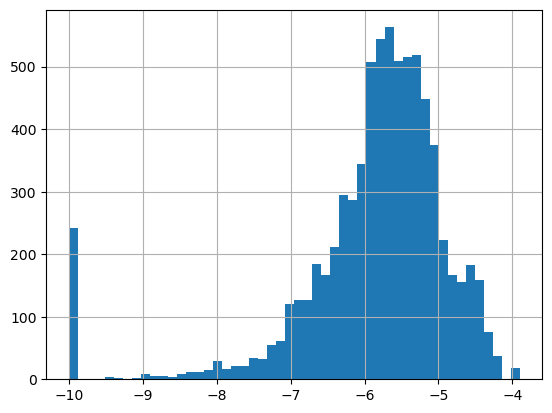

In [4]:
display(df_cycpdb_all['score'].hist(bins=50))

<AxesSubplot:>

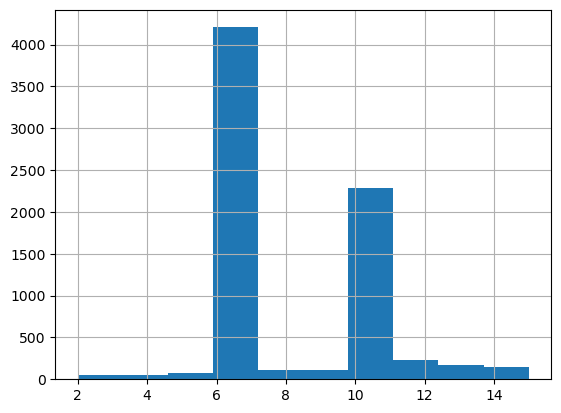

In [5]:
display(df_cycpdb_all['n_mono'].hist())

# Linear peptides

In [6]:
# check if all amino acids are natural
def check_if_all_aas_are_natural(aa_seq):
    return all([aa in 'ACDEFGHIKLMNPQRSTVWY' for aa in aa_seq])

def get_is_natural_aa(df):
    return [check_if_all_aas_are_natural(seq) for seq in df.aa_seq]

def get_helm_from_aa_seq(aa_seq):
    aa_seq = '.'.join(aa_seq)
    return f'PEPTIDE1{{{aa_seq}}}$$$$'

def get_linpep_smi_from_aa_seq(aa_seq):
    if 'X' in aa_seq:
        return None
    
    mol = Chem.MolFromSequence(aa_seq)
    if mol:
        return Chem.MolToSmiles(mol)
    else:
        return None

## CPP924

In [7]:
# train = True

if train:
    df_train_cpp924 = pd.read_csv('data/CPP924/train_ori.csv', header=None, names=['aa_seq', 'is_cpp'])
    df_test_cpp924 = pd.read_csv('data/CPP924/test_ori.csv', header=None, names=['aa_seq', 'is_cpp'])
    display(df_train_cpp924.columns)

    # df_train_cpp924['is_natural'] = get_is_natural_aa(df_train_cpp924)
    # df_test_cpp924['is_natural'] = get_is_natural_aa(df_test_cpp924)

    # display(df_train_cpp924[df_train_cpp924.is_natural == False])
    # display(df_test_cpp924[df_test_cpp924.is_natural == False])

    df_train_cpp924['helm'] = [get_helm_from_aa_seq(seq) for seq in df_train_cpp924.aa_seq]
    df_test_cpp924['helm'] = [get_helm_from_aa_seq(seq) for seq in df_test_cpp924.aa_seq]

    df_train_cpp924['smi'] = [get_linpep_smi_from_aa_seq(seq) for seq in df_train_cpp924.aa_seq]
    df_test_cpp924['smi'] = [get_linpep_smi_from_aa_seq(seq) for seq in df_test_cpp924.aa_seq]

    df_train_cpp924['n_mono'] = [count_n_monomers(helm) for helm in df_train_cpp924.helm]
    df_test_cpp924['n_mono'] = [count_n_monomers(helm) for helm in df_test_cpp924.helm]

    df_train_cpp924[['smi', 'helm', 'aa_seq', 'n_mono',  'is_cpp']].to_csv('data/CPP924/train.csv', index=False)
    df_test_cpp924[['smi', 'helm', 'aa_seq', 'n_mono',  'is_cpp']].to_csv('data/CPP924/test.csv', index=False)
else:
    df_train_cpp924 = pd.read_csv('data/CPP924/train.csv')
    df_test_cpp924 = pd.read_csv('data/CPP924/test.csv')

display(df_train_cpp924.head())

,smi,helm,aa_seq,n_mono,is_cpp
0,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)CNC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)NC(=O)[C@H](CCSC)NC(=O)[C@H](CS)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CS)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CS)NC(=O)[C@@H](N)Cc1ccccc1)C(C)C)[C@@H](C)O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)O,PEPTIDE1{F.C.N.V.A.N.Q.A.Y.K.Q.S.H.Q.C.Y.C.M.A.P.L.T.K.P.A.W.G.G.M.M.N.M.E.Y.S.F.I.Y.Y}$$$$,FCNVANQAYKQSHQCYCMAPLTKPAWGGMMNMEYSFIYY,39,1
1,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](N)CCC(N)=O)C(C)C)C(=O)O,PEPTIDE1{Q.Y.Y.K.N.P.M.V.D.F.R.Q.G.I}$$$$,QYYKNPMVDFRQGI,14,1
2,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CCSC)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N)CCCNC(=N)N)C(C)C)[C@@H](C)O)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)O)C(C)C,PEPTIDE1{R.N.F.M.S.E.V.Q.T.L.I.V.R.F}$$$$,RNFMSEVQTLIVRF,14,1
3,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](N)Cc1c[nH]c2ccccc12)C(C)C)C(C)C)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O,PEPTIDE1{W.E.L.V.V.L.G.K.L.Y.G.R.K.K.R.R.Q.R.R.R}$$$$,WELVVLGKLYGRKKRRQRRR,20,0
4,CSCC[C@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@@H](N)CC(N)=O)[C@@H](C)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@H](C(=O)O)[C@@H](C)O,PEPTIDE1{N.S.G.T.M.Q.S.A.S.R.A.T}$$$$,NSGTMQSASRAT,12,0


<AxesSubplot:>

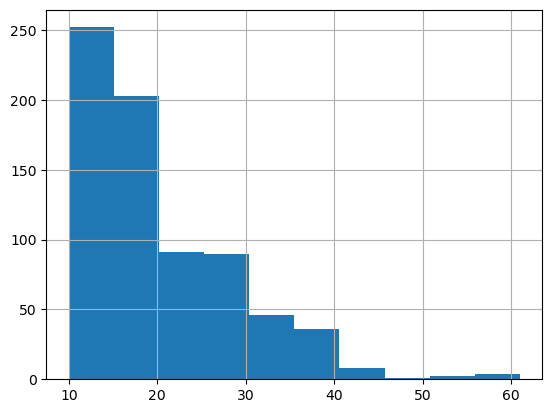

In [8]:
display(df_train_cpp924['n_mono'].hist())

<AxesSubplot:>

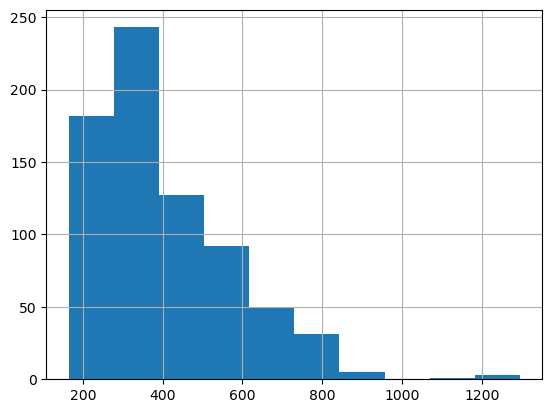

In [9]:
df_train_cpp924['smi_len'] = df_train_cpp924.smi.apply(lambda x: len(x) if x else 0)
df_test_cpp924['smi_len'] = df_test_cpp924.smi.apply(lambda x: len(x) if x else 0)

display(df_train_cpp924['smi_len'].hist())

In [10]:
df_train_cpp924.smi_len.max(), df_test_cpp924.smi_len.max()

(1295, 1228)

## MLCPP 2.0

In [11]:
# train = True

if train:
    df_mlcpp2_train = pd.read_csv('data/MLCPP2.0/Layer1_training.csv', header=None, names=['pos/neg', 'id','aa_seq'])
    df_mlcpp2_test = pd.read_csv('data/MLCPP2.0/Layer1_Independent.csv', header=None, names=['pos/neg', 'id','aa_seq'])

    df_mlcpp2_train['is_cpp'] = df_mlcpp2_train['pos/neg'].apply(lambda x: 1 if x == 'Positive' else 0)
    df_mlcpp2_test['is_cpp'] = df_mlcpp2_test['pos/neg'].apply(lambda x: 1 if x == 'Positive' else 0)

    df_mlcpp2_train['helm'] = [get_helm_from_aa_seq(seq) for seq in df_mlcpp2_train.aa_seq]
    df_mlcpp2_test['helm'] = [get_helm_from_aa_seq(seq) for seq in df_mlcpp2_test.aa_seq]

    df_mlcpp2_train['smi'] = [get_linpep_smi_from_aa_seq(seq) for seq in df_mlcpp2_train.aa_seq]
    df_mlcpp2_test['smi'] = [get_linpep_smi_from_aa_seq(seq) for seq in df_mlcpp2_test.aa_seq]

    df_mlcpp2_train['n_mono'] = [count_n_monomers(helm) for helm in df_mlcpp2_train.helm]
    df_mlcpp2_test['n_mono'] = [count_n_monomers(helm) for helm in df_mlcpp2_test.helm]

    df_mlcpp2_train[['smi', 'helm', 'aa_seq', 'n_mono',  'is_cpp']].to_csv('data/MLCPP2.0/train.csv', index=False)
    df_mlcpp2_test[['smi', 'helm', 'aa_seq', 'n_mono',  'is_cpp']].to_csv('data/MLCPP2.0/test.csv', index=False)
else:
    df_mlcpp2_train = pd.read_csv('data/MLCPP2.0/train.csv')
    df_mlcpp2_test = pd.read_csv('data/MLCPP2.0/test.csv')

display(df_mlcpp2_train.head())

,smi,helm,aa_seq,n_mono,is_cpp
0,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)CN)C(=O)N1CCC[C@H]1C(=O)O,PEPTIDE1{G.R.K.G.K.H.K.R.K.K.L.P}$$$$,GRKGKHKRKKLP,12,1
1,CSCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)O,PEPTIDE1{K.F.L.N.R.F.W.H.W.L.Q.L.K.P.G.Q.P.M.Y}$$$$,KFLNRFWHWLQLKPGQPMY,19,1
2,CC(C)[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CCCNC(=N)N)C(C)C)[C@@H](C)O)[C@@H](C)O)C(=O)O,PEPTIDE1{R.R.R.R.R.R.R.R.R.G.P.G.V.T.W.T.P.Q.A.W.F.Q.W.V}$$$$,RRRRRRRRRGPGVTWTPQAWFQWV,24,1
3,CC(C)C[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C)N)C(C)C)C(C)C)[C@@H](C)O)[C@@H](C)O)C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCCCN)C(=O)O,PEPTIDE1{A.E.K.V.D.P.V.K.L.N.L.T.L.S.A.A.A.E.A.L.T.G.L.G.D.K}$$$$,AEKVDPVKLNLTLSAAAEALTGLGDK,26,1
4,CC(C)C[C@H](NC(=O)CN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N[C@@H](CS)C(=O)O,PEPTIDE1{G.L.K.K.L.A.R.L.F.H.K.L.L.K.L.G.C}$$$$,GLKKLARLFHKLLKLGC,17,1


<AxesSubplot:>

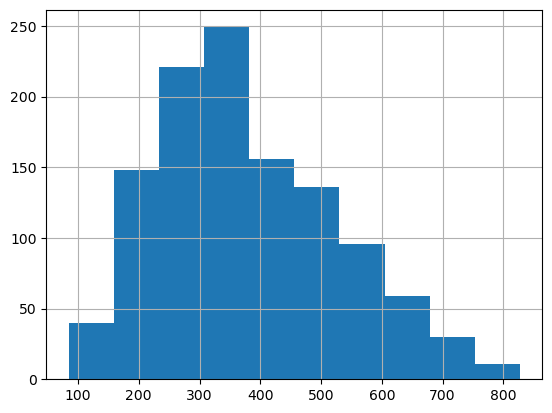

In [12]:
df_mlcpp2_train['smi_len'] = df_mlcpp2_train.smi.apply(lambda x: len(x) if x else 0)
df_mlcpp2_test['smi_len'] = df_mlcpp2_test.smi.apply(lambda x: len(x) if x else 0)

display(df_mlcpp2_train['smi_len'].hist())

In [13]:
df_mlcpp2_train['smi_len'].max(), df_mlcpp2_test['smi_len'].max()

(827, 1295)

# Dataset to pretrain the SMILES BERT

In [6]:
from sklearn.model_selection import train_test_split

df_smi_pretrain = pd.read_csv('data/smi_pretrain/pretrain.csv', header=None, names=['smi'])
train_data, valid_data = train_test_split(df_smi_pretrain, test_size=0.1, random_state=1)

train_data.to_csv('data/smi_pretrain/train.csv', index=False)
valid_data.to_csv('data/smi_pretrain/val.csv', index=False)

len(df_smi_pretrain), len(train_data), len(valid_data)

(4978885, 4480996, 497889)